## Récupérer les données

Aller sur https://www.facebook.com/groups/470511086490229/post_tags_list/ et copier-coller ce qui est dans l'ensemble des cartes dans un fichier `/eco-colocs`

Retirer les lignes où il n'y a pas de valeur (exemple "auto-reportage" s'il n'y a pas de posts donc pas de valeur indiquée)

Parsing des données pour les sortir au format tabulaire (CSV)

In [1]:
!cat eco-colocs.txt |\
    grep -P " et |publication" |\
    sed -e 's_ et .*__g'|\
    sed -e '{:a;N;$!ba;s_\n__g}' \
        -e 's_\([0-9]\+\) publications*_,\1\n_g'|\
    grep -v -P '^,' \
    > par-prefecture.csv

## Chargement des données en mémoire

In [2]:
import pandas

In [3]:
ecocolocs = pandas.read_csv("par-prefecture.csv", sep=",", names=["Ville", "nombre"]).set_index(["Ville"])

## Visualisation des données

<AxesSubplot:ylabel='Ville'>

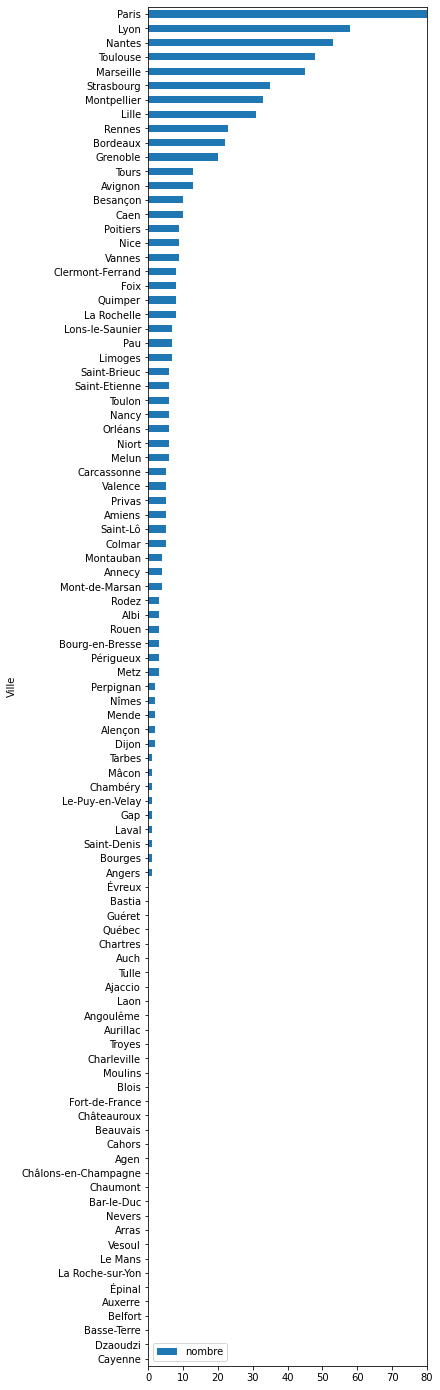

In [4]:
ecocolocs.sort_values(by="nombre", ascending=True).plot.barh(figsize=(5,25), xlim=(0,80))

<AxesSubplot:ylabel='Ville'>

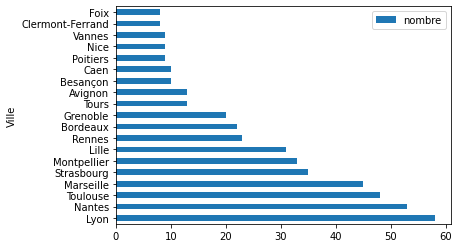

In [5]:
ecocolocs.sort_values(by="nombre", ascending=False)[1:20].plot.barh()

In [6]:
import geopandas as gpd
from matplotlib import pyplot as plt

In [7]:
gps_list = []

for row in ecocolocs.iterrows():
    city = row[0]
    total = row[1].nombre
    !if [ ! -f cities/"$city".json ] ;then wget https://nominatim.openstreetmap.org/search/"$city"?format=json -O cities/"$city".json 2>> /tmp/err;fi
    
    lat = !cat cities/"$city".json |jq '.[0].lat' | sed 's_"__g'
    lon = !cat cities/"$city".json |jq '.[0].lon' | sed 's_"__g'
    
    try:
        gps_list.append({
            "city": city,
            "total": total,
            "pref_lat": lat[0],
            "pref_lon": lon[0]
        })

    except:
        print(city)

In [8]:
gps = pandas.DataFrame(gps_list).set_index(["city"])

In [9]:
gdf = gpd.GeoDataFrame(
    gps, geometry=gpd.points_from_xy(gps.pref_lon, gps.pref_lat))

In [10]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [13]:
from datetime import datetime

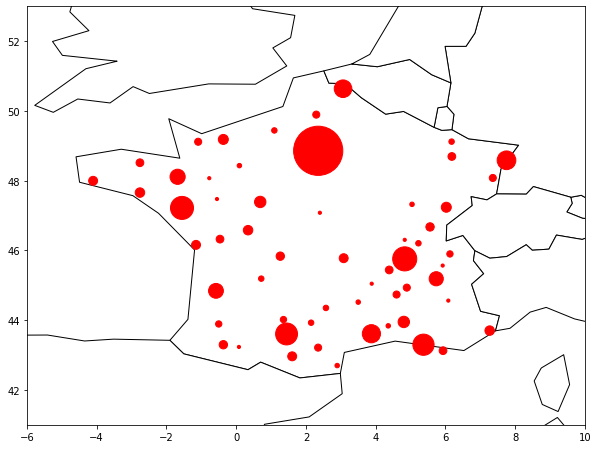

In [14]:
ax = world.plot(color='white', edgecolor='black', figsize=(10,10))
ax.set_xlim(-6,10)
ax.set_ylim(41,53)

gdf.plot(ax=ax, color='red', markersize = gps.total * 10)

plt.savefig("images/{}.png".format(datetime.strftime(datetime.now(), "%Y-%m-%d")))

In [15]:
!convert -loop 0 -delay 30 images/2020-* eco-colocations.gif

In [16]:
# à exécuter dans une console :
# . login.sh
!git add images/. eco-colocs.txt && git commit -m "Valeurs du jours"
# à exécuter dans une console :
# git push origin master

[master 01ca71b] Valeurs du jours
 4 files changed, 32 insertions(+), 32 deletions(-)
 create mode 100644 images/.ipynb_checkpoints/2020-07-29-checkpoint.png
 create mode 100644 images/.ipynb_checkpoints/2020-08-08-checkpoint.png
 create mode 100644 images/2020-08-08.png
